In [4]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.regularizers import l2
from keras.layers import TimeDistributed, Bidirectional, BatchNormalization, Dropout, Input, Add, Masking
from keras import Model
import pdb
import pandas as pd
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.callbacks import ModelCheckpoint
import glob
import sys
from sklearn.metrics import auc
import pickle


In [5]:
BATCH_SIZE = 64
INPUT_SEQ_LEN_MODEL1 = 10
INPUT_NUM_CH_MODEL1 = 5
INPUT_FEATS_MODEL2 = 33

In [26]:
def roc(predictions, true, filename):
    predictions = predictions.flatten()
    true = true.flatten()

    thresh_vals = np.linspace(np.min(predictions), np.max(predictions), 50)
    results = []
    for thresh in thresh_vals:
        tmp_predictions = (predictions > thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(true, tmp_predictions).ravel()
        tpr = tp/(tp+fn)
        fpr = fp/(tn+fp)
        acc = (tp+tn)/(tn+fp+fn+tp)

        tmp_dict = {'acc': acc, 'tpr': tpr, 'fpr': fpr, 'thresh': thresh}
        results.append(tmp_dict)

    results = pd.DataFrame(results)
    results = results.sort_values(by='thresh', ascending=False)
    
    #calculate the AUC
    AUC = auc(results['fpr'].values, results['tpr'].values)

    plt.figure(figsize=(10,6))
    plt.plot(results['fpr'], results['tpr'], '*-')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC\nAUC=%.2f' % AUC)
    plt.tight_layout()
    plt.savefig('ROC_%s.png' % filename, dpi=250)
    plt.show()

    results = results.sort_values(by='acc', ascending=False)
    final_thresh = results.head(1)['thresh'].values[0]

    return results, final_thresh

In [7]:
#load the training data
train = pd.read_pickle('train.pkl').reset_index(drop=True)

#define the validation set as 15% of the training set
N = len(train)
train = train.sample(frac=1).reset_index(drop=True)
val = train[:int(N*0.2)]
train = train[int(N*0.2):]

#separate out the training data
#note that input data for LSTM should be in the format of (number_samples, sequence_len, num_channels)
y_train = np.asarray(list(train['label']))
y_train = to_categorical(y_train)
X_train_cont = np.asarray(list(train['X_cont'].values))
X_train_cat = train.drop(['X_cont', 'label'], axis=1)

#for the mask layer, any NaN values need to be replaced by a unique value. use the constant np.pi
X_train_cat[X_train_cat.isna()] = np.pi
X_train_cat = np.asarray(list(X_train_cat.values))

#separate out the training data
y_val = np.asarray(list(val['label']))
y_val = to_categorical(y_val)
X_val_cont = np.asarray(list(val['X_cont'].values))
X_val_cat = val.drop(['X_cont', 'label'], axis=1)

#replace NaN with pi
X_val_cat[X_val_cat.isna()] = np.pi
X_val_cat = np.asarray(list(X_val_cat.values))

#load the test data
test = pd.read_pickle('test.pkl')
y_test = np.asarray(list(test['label']))
y_test = to_categorical(y_test)
X_test_cont = np.asarray(list(test['X_cont'].values))
X_test_cat = test.drop(['X_cont', 'label'], axis=1)

#replace NaN with pi
X_test_cat[X_test_cat.isna()] = np.pi
X_test_cat = np.asarray(list(X_test_cat.values))

In [52]:
train.shape

(776772, 35)

In [50]:
test.shape

(168314, 35)

In [18]:
count_class_0 = np.sum(y_train[:,1].astype(int)==0)
count_class_1 = np.sum(y_train[:, 1].astype(int) == 1)
max_class_counts = np.max((count_class_0, count_class_1))
class_weights = {0: max_class_counts/count_class_0, 1: max_class_counts/count_class_1}
print('class weights -- no sepsis: {}, sepsis: {}'.format(class_weights[0], class_weights[1]))


class weights -- no sepsis: 1.0, sepsis: 54.12931156848829


In [19]:
input1 = Input(shape=(INPUT_SEQ_LEN_MODEL1, INPUT_NUM_CH_MODEL1))
model1 = Bidirectional(LSTM(100, kernel_regularizer=l2(0.001), return_sequences=True))(input1)
model1 = Bidirectional(LSTM(75, kernel_regularizer=l2(0.001)))(model1)
model1 = Dense(35, kernel_regularizer=l2(0.001), activation='relu')(model1)
model1 = BatchNormalization()(model1)
model1 = Dense(15, kernel_regularizer=l2(0.001), activation='relu')(model1)
model1 = BatchNormalization()(model1)

input2 = Input(shape=(INPUT_FEATS_MODEL2,))
model2 = Masking(mask_value=np.pi)(input2)
model2 = Dense(30, kernel_regularizer=l2(0.001), activation='relu')(model2)
model2 = BatchNormalization()(model2)
model2 = Dense(15, kernel_regularizer=l2(0.001), activation='relu')(model2)
model2 = BatchNormalization()(model2)

model_add = Add()([model1, model2])
output = Dense(2, kernel_regularizer=l2(0.001), activation='softmax')(model_add)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 5)]              0         []                            
                                                                                                  
 bidirectional (Bidirection  (None, 10, 200)              84800     ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 input_2 (InputLayer)        [(None, 33)]                 0         []                            
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 150)                  165600    ['bidirectional[0][0]']   

In [20]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
history = model.fit([X_train_cont, X_train_cat],
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=50,
                    validation_data=([X_val_cont, X_val_cat], y_val),
                    callbacks=[earlystop, checkpoint],
                    class_weight=class_weights,
                    verbose=1)

#save the history
pickle.dump(history, open('history.pkl', 'wb'))


2023-11-20 18:41:14.265824: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 155354400 exceeds 10% of free system memory.


Epoch 1/50
12137/12138 [============================>.] - ETA: 0s - loss: 1.3102
Epoch 1: val_loss improved from inf to 0.74240, saving model to model.h5
12138/12138 [==============================] - 261s 21ms/step - loss: 1.3102 - val_loss: 0.7424
Epoch 2/50
    1/12138 [..............................] - ETA: 5:30 - loss: 1.5709

/home/kenneth/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


12137/12138 [============================>.] - ETA: 0s - loss: 1.1867
Epoch 2: val_loss improved from 0.74240 to 0.22968, saving model to model.h5
12138/12138 [==============================] - 302s 25ms/step - loss: 1.1867 - val_loss: 0.2297
Epoch 3/50
12138/12138 [==============================] - ETA: 0s - loss: 1.1601
Epoch 3: val_loss did not improve from 0.22968
12138/12138 [==============================] - 312s 26ms/step - loss: 1.1601 - val_loss: 0.8256
Epoch 4/50
12136/12138 [============================>.] - ETA: 0s - loss: 1.1439
Epoch 4: val_loss did not improve from 0.22968
12138/12138 [==============================] - 308s 25ms/step - loss: 1.1440 - val_loss: 0.8040
Epoch 5/50
12137/12138 [============================>.] - ETA: 0s - loss: 1.1363
Epoch 5: val_loss did not improve from 0.22968
12138/12138 [==============================] - 326s 27ms/step - loss: 1.1363 - val_loss: 0.6807
Epoch 6/50
12136/12138 [============================>.] - ETA: 0s - loss: 1.1275
Epoc

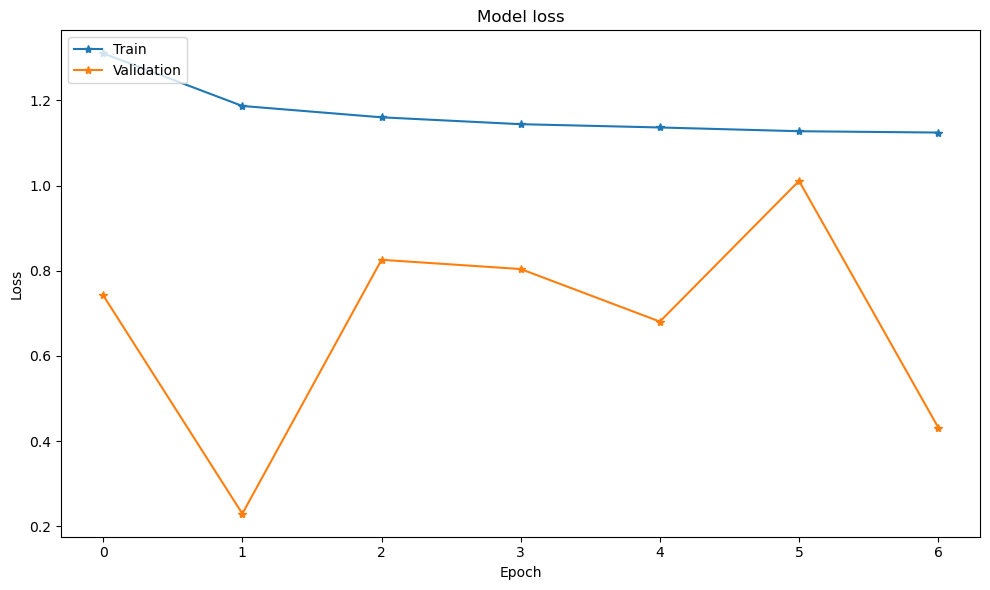

In [22]:
# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], '*-')
plt.plot(history.history['val_loss'], '*-')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.savefig('loss.png', dpi=250)
plt.show()
plt.close()

6069/6069 [==============================] - 30s 5ms/step


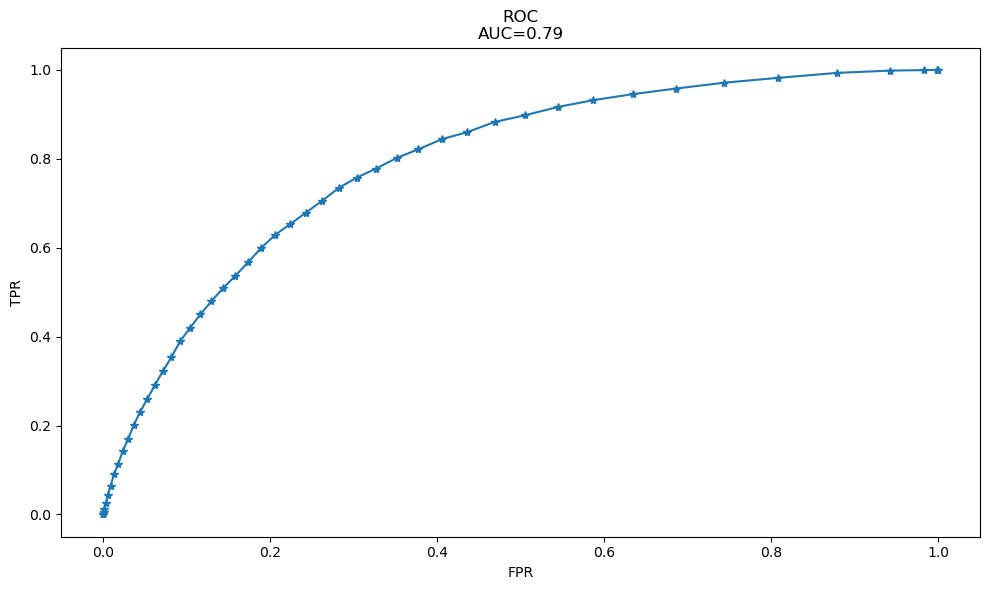

In [27]:
predictions = model.predict([X_val_cont, X_val_cat])

results_df, thresh_final = roc(predictions[:,1].flatten(), y_val[:,1].flatten(), 'val')
results_df = results_df.sort_values(by='fpr')

5260/5260 [==============================] - 25s 5ms/step


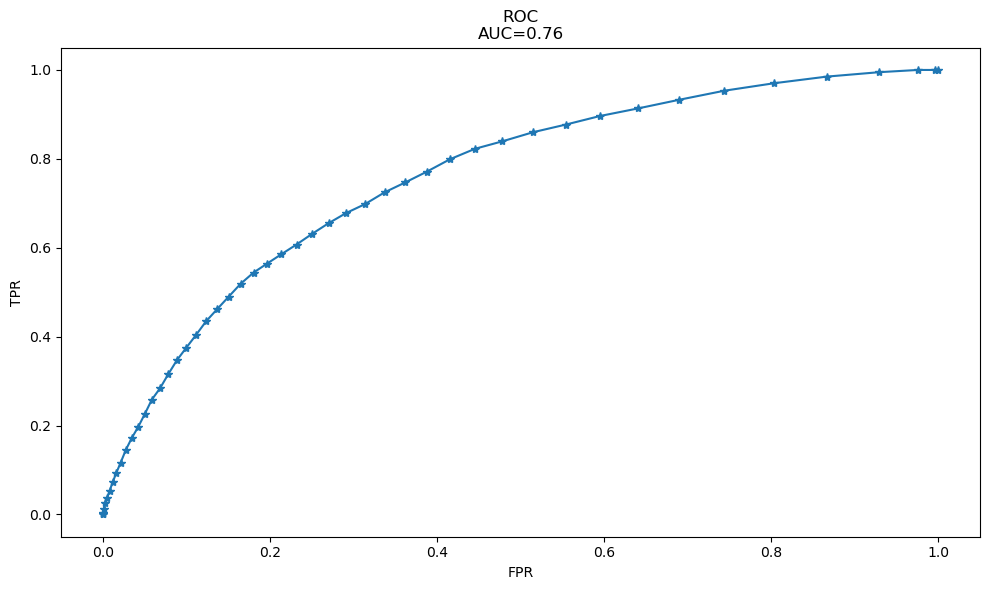

In [28]:
predictions = model.predict([X_test_cont, X_test_cat])

results_df, thresh_final = roc(predictions[:,1].flatten(), y_test[:,1].flatten(), 'test')
results_df = results_df.sort_values(by='fpr')
